## **Plant Doctor**


In [ ]:
!mkdir plantdisease

!curl -L -o plantdisease.zip\
  https://www.kaggle.com/api/v1/datasets/download/emmarex/plantdisease


In [2]:
%%capture
!unzip plantdisease.zip -d plantdisease/

In [7]:
import random

import numpy as np
import torch

def set_global_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_global_random_seed(42)

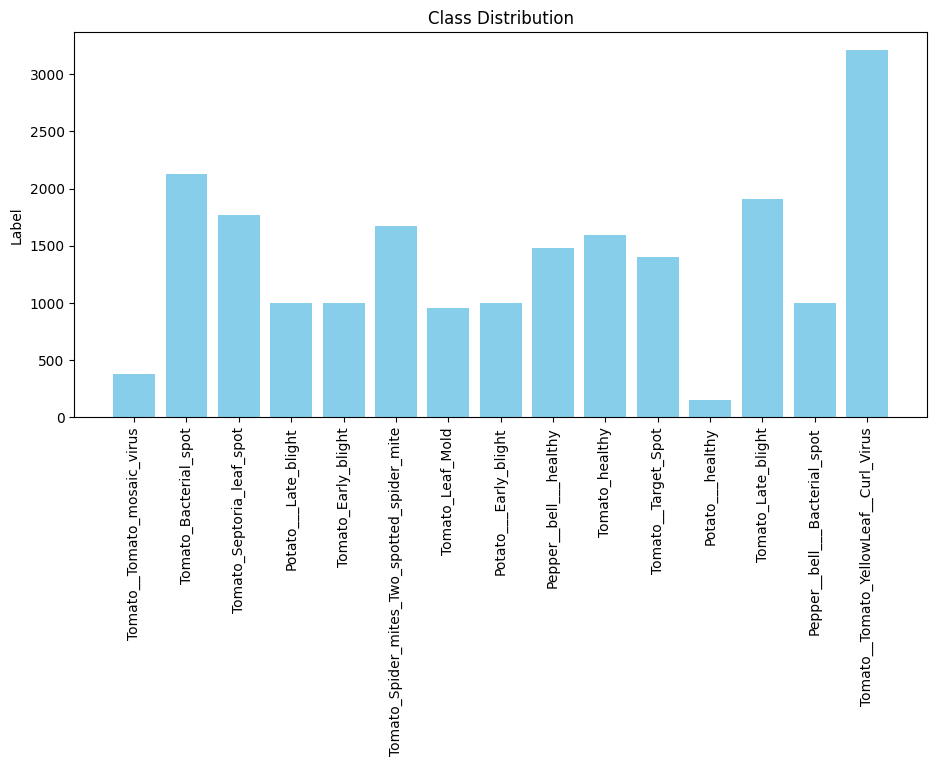

In [8]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("plantdisease/PlantVillage")

labels = os.listdir(path)
counts = [len(os.listdir(os.path.join(path, label))) for label in labels]

plt.figure(figsize=(11, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel("Image count")
plt.ylabel("Label")

plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

### Data Loading


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_data(path):
    data = []

    for p in path.iterdir():
        for image in p.iterdir():
            if image.suffix.lower() == ".jpg":
                data.append((image, image.parents[0].stem))

    return pd.DataFrame(data, columns=['path', 'label'])

df = load_data(path)

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14857, 2)
(1651, 2)
(4128, 2)


In [91]:
label_map = {label: i for i, label in enumerate(os.listdir(path))}
print(label_map)
i_to_label = {i : label for label, i in label_map.items()}

{'Tomato__Tomato_mosaic_virus': 0, 'Tomato_Bacterial_spot': 1, 'Tomato_Septoria_leaf_spot': 2, 'Potato___Late_blight': 3, 'Tomato_Early_blight': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato_Leaf_Mold': 6, 'Potato___Early_blight': 7, 'Pepper__bell___healthy': 8, 'Tomato_healthy': 9, 'Tomato__Target_Spot': 10, 'Potato___healthy': 11, 'Tomato_Late_blight': 12, 'Pepper__bell___Bacterial_spot': 13, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 14}


In [11]:
from torch.utils import data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor


class Data(data.Dataset):
    def __init__(self, df, label_map, transforms=None):
        super().__init__()

        self.df = df

        self.label_map = label_map
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255

        if self.transforms is not None:
            img = img.permute(1, 2, 0).numpy()
            img = self.transforms(image=img)['image']

        return img, self.label_map[sample.label]


train = Data(train_df, label_map)
valid = Data(valid_df, label_map)
test = Data(test_df, label_map)

### Data Normalization


In [12]:
from tqdm import tqdm


def get_dataset_stats(ds):
    images = torch.stack([im[0] for im in tqdm(ds)])

    ds_mean = images.mean(dim=(0, 2, 3))
    ds_std = images.std(dim=(0, 2, 3))

    return ds_mean.tolist(), ds_std.tolist()


mean, std = get_dataset_stats(train)
print(f'Dataset stats\n  mean:\t {mean}\n  std:\t {std}' )


100%|██████████| 14857/14857 [03:50<00:00, 64.41it/s]


Dataset stats
  mean:	 [0.4583975076675415, 0.4747447073459625, 0.4113084673881531]
  std:	 [0.19250939786434174, 0.1699002981185913, 0.20675981044769287]


In [13]:
def ishow(img,
          cmap='viridis',
          title='',
          fig_size=(8,6),
          colorbar=False,
          interpolation='none'):
    ' Function `ishow` displays an image in a new window. '

    #extent = (0, img.shape[1], img.shape[0], 0)
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(img,
              #extent=extent,
              cmap=cmap,
              interpolation=interpolation)

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation='vertical')
    plt.show()

### Data Augmentation

In [14]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(8, 8))

    cols, rows = n_samples, n_samples
    sample_img, label = ds[idx]

    for i in range(1, cols * rows + 1):
        img, _ = ds[idx]

        img_np = img.permute(1, 2, 0).cpu().detach().numpy()

        if img_np.min() < 0 or img_np.max() > 1:

            print(f'The image values were shifted to the range (0, 1). The original range is ({img.min():.04f}), {img.max():.04f})')
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            print(img_np.min(), img_np.max())
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img_np)

    plt.suptitle(f'sample no {idx}, label {label}')
    plt.tight_layout()
    plt.show()


In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(224,224), # for vgg
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Rotate(limit=30, p=0.5),
    #A.GaussianBlur(blur_limit=3, p=0.1),
    #A.GaussNoise(p=0.1),
    #A.CenterCrop(width=56, height=56),
    #A.ElasticTransform(p=0.3),
    A.CLAHE(clip_limit=2, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
    A.Normalize(
        mean=mean,
        std=std,
        normalization="image_per_channel"
    ),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(
        mean=mean,
        std=std,
        normalization="image_per_channel"
    ),
    ToTensorV2()
])

train = Data(train_df, label_map, train_transform)
valid = Data(valid_df, label_map, valid_transform)
test = Data(test_df, label_map, valid_transform)

The image values were shifted to the range (0, 1). The original range is (-2.2431), 2.3598)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.9586), 3.2210)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.2440), 3.1135)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.2440), 3.1135)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.5637), 2.8609)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.6266), 2.5099)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.2440), 3.1135)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.4243), 2.5501)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.3334), 3.1617)
0.0 1.0


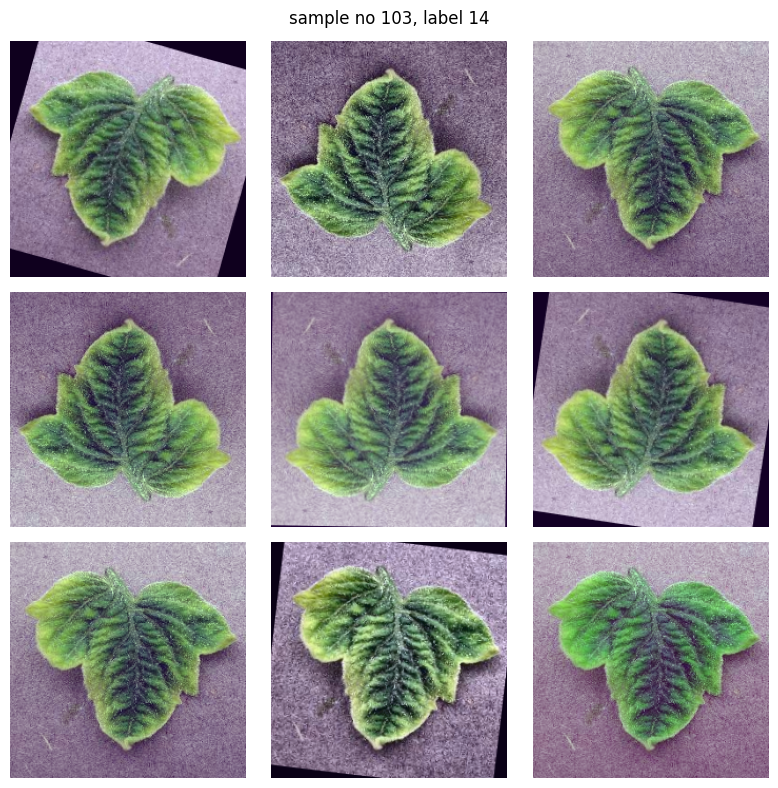

In [16]:
show_augmentations(train, 103)

In [17]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

# rebalance the classes
class_counts = train_df['label'].value_counts().rename("count")
class_weights = (1.0 / class_counts).rename("weight")
class_weights /= class_weights.sum()
sample_weights = train_df['label'].map(class_weights).astype(np.float32).values

sampler = WeightedRandomSampler(weights=sample_weights.tolist(), num_samples=len(sample_weights), replacement=True)

In [18]:
print(pd.concat([class_counts, class_weights], axis=1))

                                             count    weight
label                                                       
Tomato__Tomato_YellowLeaf__Curl_Virus         2299  0.016514
Tomato_Bacterial_spot                         1576  0.024090
Tomato_Late_blight                            1372  0.027671
Tomato_Septoria_leaf_spot                     1252  0.030324
Tomato_Spider_mites_Two_spotted_spider_mite   1197  0.031717
Tomato_healthy                                1144  0.033186
Pepper__bell___healthy                        1064  0.035682
Tomato__Target_Spot                           1005  0.037776
Tomato_Early_blight                            741  0.051235
Pepper__bell___Bacterial_spot                  727  0.052222
Potato___Early_blight                          724  0.052438
Potato___Late_blight                           704  0.053928
Tomato_Leaf_Mold                               672  0.056496
Tomato__Tomato_mosaic_virus                    274  0.138559
Potato___healthy        

### Models

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class WrappedDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):  # send only one batch to the device every iteration
        batches = iter(self.dataloader)
        for x, y in batches:
            yield x.to(self.device), y.to(self.device)

bs = 128

train_dataloader = WrappedDataLoader(DataLoader(train, batch_size=bs, sampler=sampler), device)
val_dataloader = WrappedDataLoader(DataLoader(valid, batch_size=bs, shuffle=True), device)
test_dataloader = WrappedDataLoader(DataLoader(test, batch_size=bs), device)

In [20]:
import math
from copy import deepcopy


def update(model, loss_f, inputs, targets, optimizer=None):

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_f(outputs, targets)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), len(inputs), torch.sum(preds == targets.data)


def train(epochs, model, loss_f, optimizer, scheduler, train_dl, valid_dl):
    val_loss = []
    train_loss = []
    best_acc = -math.inf
    state_dict = model.state_dict()

    for epoch in range(epochs):

        model.train()

        losses, inputs_size, _ = zip(*[update(model, loss_f, inputs, targets, optimizer)
                                           for inputs, targets in tqdm(train_dl)])

        epoch_train_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(inputs_size)
        train_loss.append(epoch_train_loss)

        scheduler.step()

        model.eval()

        with torch.no_grad():
            losses, inputs_size, corrects = zip(*[update(model, loss_f, inputs, targets)
                                                  for inputs, targets in valid_dl])

        epoch_val_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(inputs_size)
        val_loss.append(epoch_val_loss)

        epoch_val_acc = np.sum([c.cpu().numpy() for c in corrects]) / np.sum(inputs_size)

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            state_dict = deepcopy(model.state_dict())
            print(f'New best Acc: {best_acc:4f}')

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.5f}, Validation Loss: {epoch_val_loss:.5f}")


    model.load_state_dict(state_dict)
    return train_loss, val_loss

In [21]:
import torchvision.models as models
from torch import nn
from torchsummary import summary


vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

summary(vgg19, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [22]:
for param in vgg19.features.parameters():
    param.requires_grad = False


num_in_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(in_features=num_in_features, out_features=len(label_map)).to(device)

In [23]:
torch.set_float32_matmul_precision("high")

100%|██████████| 117/117 [05:39<00:00,  2.90s/it]


New best Acc: 0.737735
Epoch 1/10, Training Loss: 1.64032, Validation Loss: 0.85008


100%|██████████| 117/117 [05:56<00:00,  3.05s/it]


New best Acc: 0.798304
Epoch 2/10, Training Loss: 0.92529, Validation Loss: 0.64411


100%|██████████| 117/117 [05:35<00:00,  2.87s/it]


New best Acc: 0.818292
Epoch 3/10, Training Loss: 0.77213, Validation Loss: 0.57047


100%|██████████| 117/117 [05:08<00:00,  2.64s/it]


New best Acc: 0.835857
Epoch 4/10, Training Loss: 0.67767, Validation Loss: 0.51162


100%|██████████| 117/117 [05:18<00:00,  2.72s/it]


New best Acc: 0.845548
Epoch 5/10, Training Loss: 0.63826, Validation Loss: 0.47850


100%|██████████| 117/117 [05:31<00:00,  2.83s/it]


New best Acc: 0.846760
Epoch 6/10, Training Loss: 0.59899, Validation Loss: 0.46911


100%|██████████| 117/117 [05:18<00:00,  2.72s/it]


New best Acc: 0.852816
Epoch 7/10, Training Loss: 0.60194, Validation Loss: 0.46347


100%|██████████| 117/117 [05:40<00:00,  2.91s/it]


New best Acc: 0.855239
Epoch 8/10, Training Loss: 0.59492, Validation Loss: 0.46230


100%|██████████| 117/117 [05:10<00:00,  2.65s/it]


Epoch 9/10, Training Loss: 0.59286, Validation Loss: 0.45869


100%|██████████| 117/117 [05:05<00:00,  2.61s/it]


Epoch 10/10, Training Loss: 0.57299, Validation Loss: 0.45493


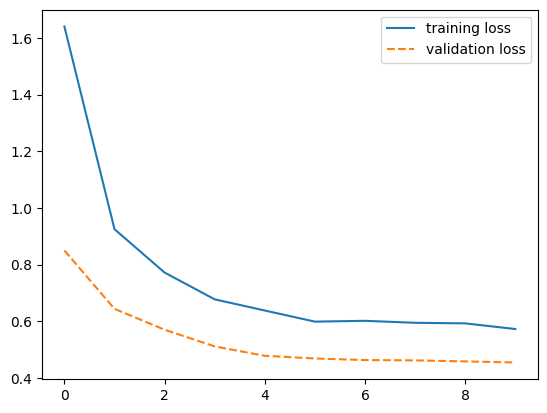

In [24]:
import torch.optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg19.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss, val_loss = train(epochs=10, model=vgg19, loss_f=loss_func, optimizer=optimizer,
                             scheduler=scheduler,train_dl=train_dataloader, valid_dl=val_dataloader)
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle='--')
plt.legend(['training loss',
           'validation loss'])
plt.show()

100%|██████████| 117/117 [05:16<00:00,  2.70s/it]


New best Acc: 0.862508
Epoch 1/15, Training Loss: 0.56820, Validation Loss: 0.42923


100%|██████████| 117/117 [05:25<00:00,  2.78s/it]


New best Acc: 0.869776
Epoch 2/15, Training Loss: 0.52987, Validation Loss: 0.41129


100%|██████████| 117/117 [05:28<00:00,  2.81s/it]


Epoch 3/15, Training Loss: 0.50619, Validation Loss: 0.40230


100%|██████████| 117/117 [05:26<00:00,  2.79s/it]


New best Acc: 0.874016
Epoch 4/15, Training Loss: 0.49702, Validation Loss: 0.38798


100%|██████████| 117/117 [05:43<00:00,  2.93s/it]


Epoch 5/15, Training Loss: 0.48243, Validation Loss: 0.38748


100%|██████████| 117/117 [05:19<00:00,  2.73s/it]


New best Acc: 0.874621
Epoch 6/15, Training Loss: 0.49734, Validation Loss: 0.38726


100%|██████████| 117/117 [05:18<00:00,  2.72s/it]


New best Acc: 0.875833
Epoch 7/15, Training Loss: 0.48724, Validation Loss: 0.38648


100%|██████████| 117/117 [05:16<00:00,  2.70s/it]


Epoch 8/15, Training Loss: 0.49710, Validation Loss: 0.38578


100%|██████████| 117/117 [05:08<00:00,  2.64s/it]


Epoch 9/15, Training Loss: 0.50677, Validation Loss: 0.38570


100%|██████████| 117/117 [05:13<00:00,  2.68s/it]


Epoch 10/15, Training Loss: 0.50228, Validation Loss: 0.38563


100%|██████████| 117/117 [05:32<00:00,  2.84s/it]


Epoch 11/15, Training Loss: 0.50749, Validation Loss: 0.38557


100%|██████████| 117/117 [05:28<00:00,  2.81s/it]


Epoch 12/15, Training Loss: 0.49326, Validation Loss: 0.38554


100%|██████████| 117/117 [05:23<00:00,  2.76s/it]


Epoch 13/15, Training Loss: 0.49746, Validation Loss: 0.38554


100%|██████████| 117/117 [05:34<00:00,  2.86s/it]


Epoch 14/15, Training Loss: 0.49896, Validation Loss: 0.38555


100%|██████████| 117/117 [05:24<00:00,  2.77s/it]


Epoch 15/15, Training Loss: 0.50039, Validation Loss: 0.38553


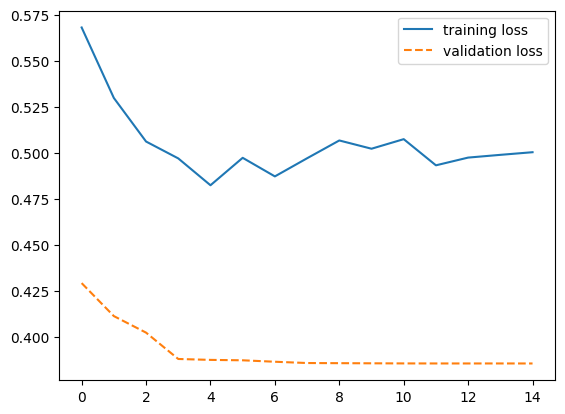

In [25]:
for param in vgg19.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(vgg19.parameters(), lr=1e-5, weight_decay=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_loss, val_loss = train(epochs=15, model=vgg19, loss_f=loss_func, optimizer=optimizer, scheduler=scheduler,
                             train_dl=train_dataloader, valid_dl=val_dataloader)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle='--')
plt.legend(['training loss',
           'validation loss'])
plt.show()

In [26]:
torch.save(vgg19.state_dict(), 'vgg19_model.pth')

### Evaluation

In [105]:
loss_func_eval = nn.CrossEntropyLoss(reduction="none")

def evaluate(model, test_dl):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for batch, targets in tqdm(test_dl):
            batch, targets = batch.to(device), targets.to(device)

            outputs = model(batch)
            _, preds = torch.max(outputs, 1)
            
            loss = loss_func_eval(outputs, targets)
            losses.extend(loss.cpu().numpy())

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred, np.array(losses)

y_true, y_pred, losses = evaluate(vgg19, test_dataloader)

100%|██████████| 33/33 [01:15<00:00,  2.27s/it]


100%|██████████| 13/13 [00:25<00:00,  1.96s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7634058..2.5140302].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5265508..3.0474634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.0708427..2.699706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.203225..1.9297805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.33855..1.6700531].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.39855..2.197425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0.

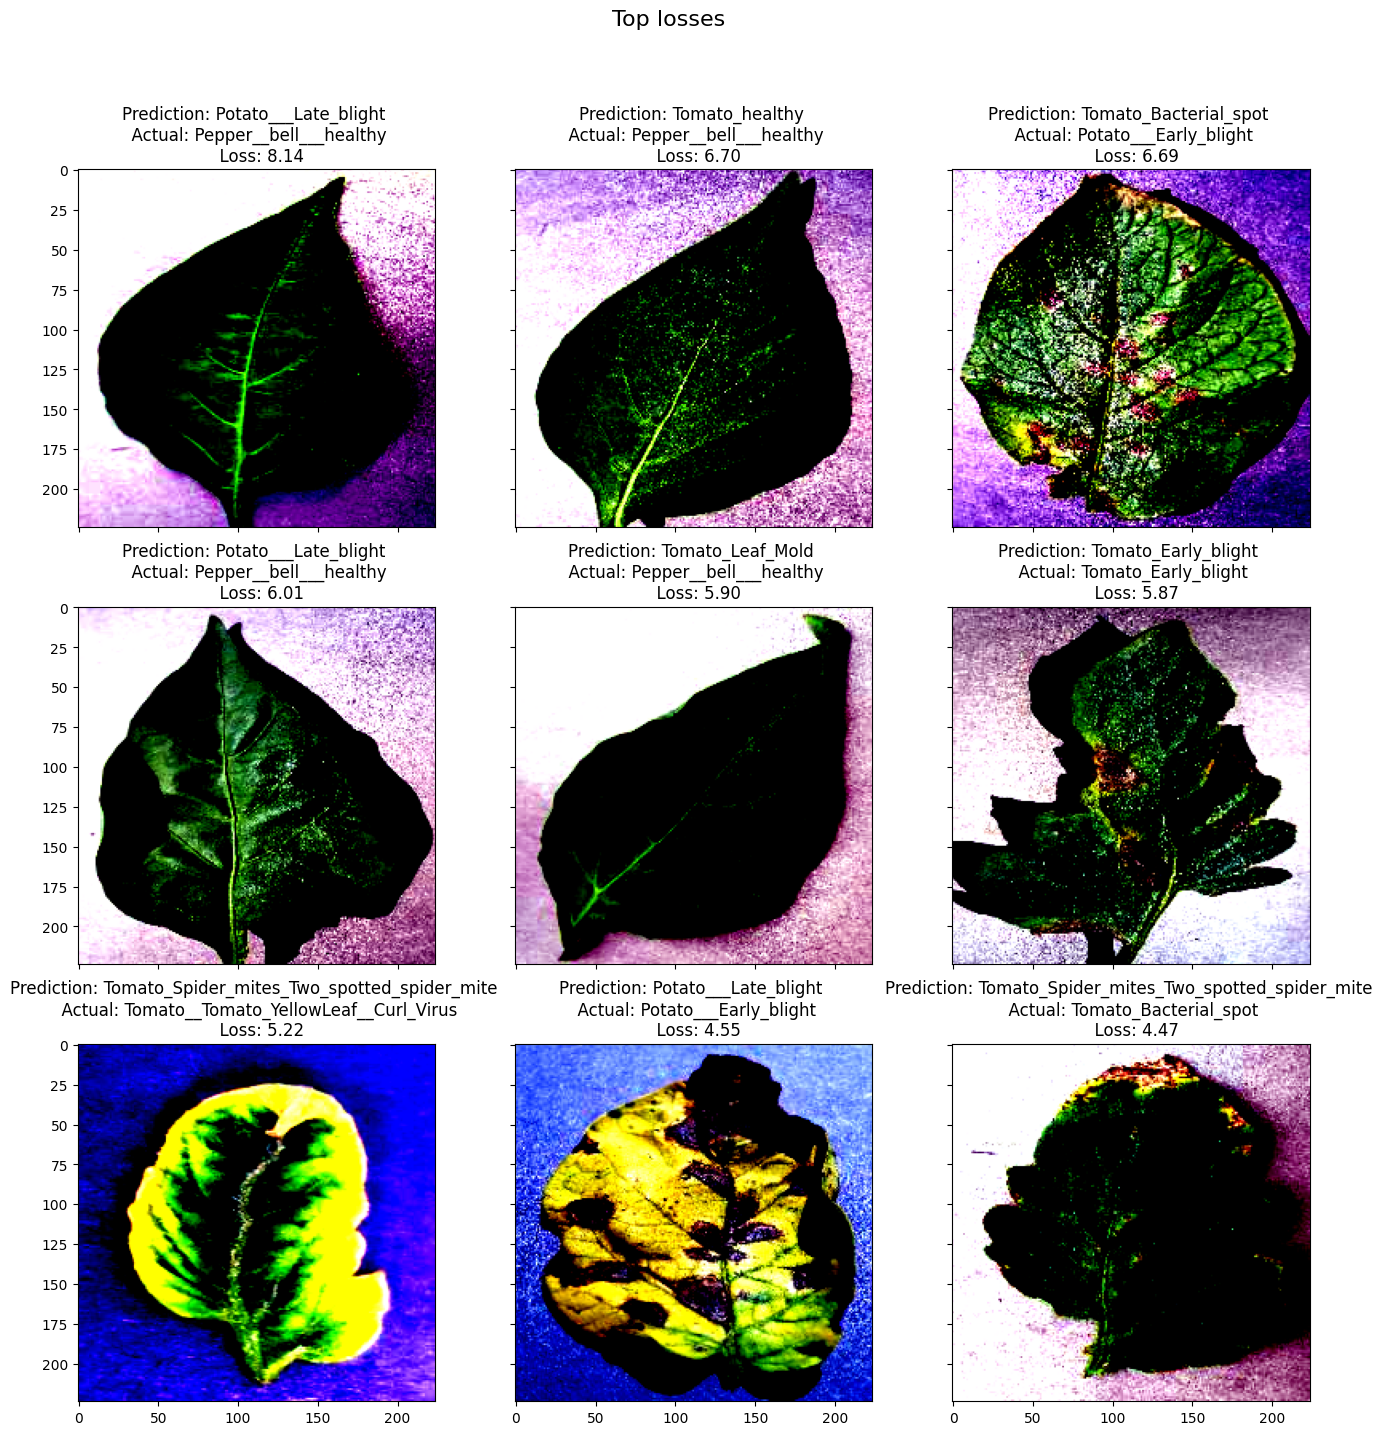

In [121]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def get_top_n_loss_idx(losses_np: np.array, n: int = 9):
    top_n_losses_i = (-losses_np).argsort()[:n]
    return top_n_losses_i


def plot_top_losses(ds: Data, losses_np: np.array, y_pred, n: int = 9, title: str = "Top losses"):

    grid_size = int(math.sqrt(n))
    top_n_losses_i = get_top_n_loss_idx(losses_np, n)

    images = [ds[i] for i in top_n_losses_i]
    fig = plt.figure(figsize=(20, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(grid_size, grid_size), axes_pad=0.8)

    fig.suptitle(title, fontsize=16)
    predicted = np.array(y_pred)[top_n_losses_i]
    top_n_losses = losses_np[top_n_losses_i]
    
    for ax, img_label, y_predicted, loss in zip(grid, images, predicted, top_n_losses):
        img, label = img_label
        
        title = f"Prediction: {i_to_label[y_predicted.item()]} \n  Actual: {i_to_label[label]} \n  Loss: {loss:.2f}"

        img_np = img.permute(1, 2, 0).cpu().detach().numpy()
        ax.imshow(img_np)
        ax.set_title(title)

    plt.show()


y_true_val, y_pred_val, losses_val = evaluate(vgg19, val_dataloader)
plot_top_losses(valid, losses_val, y_pred_val, 9)

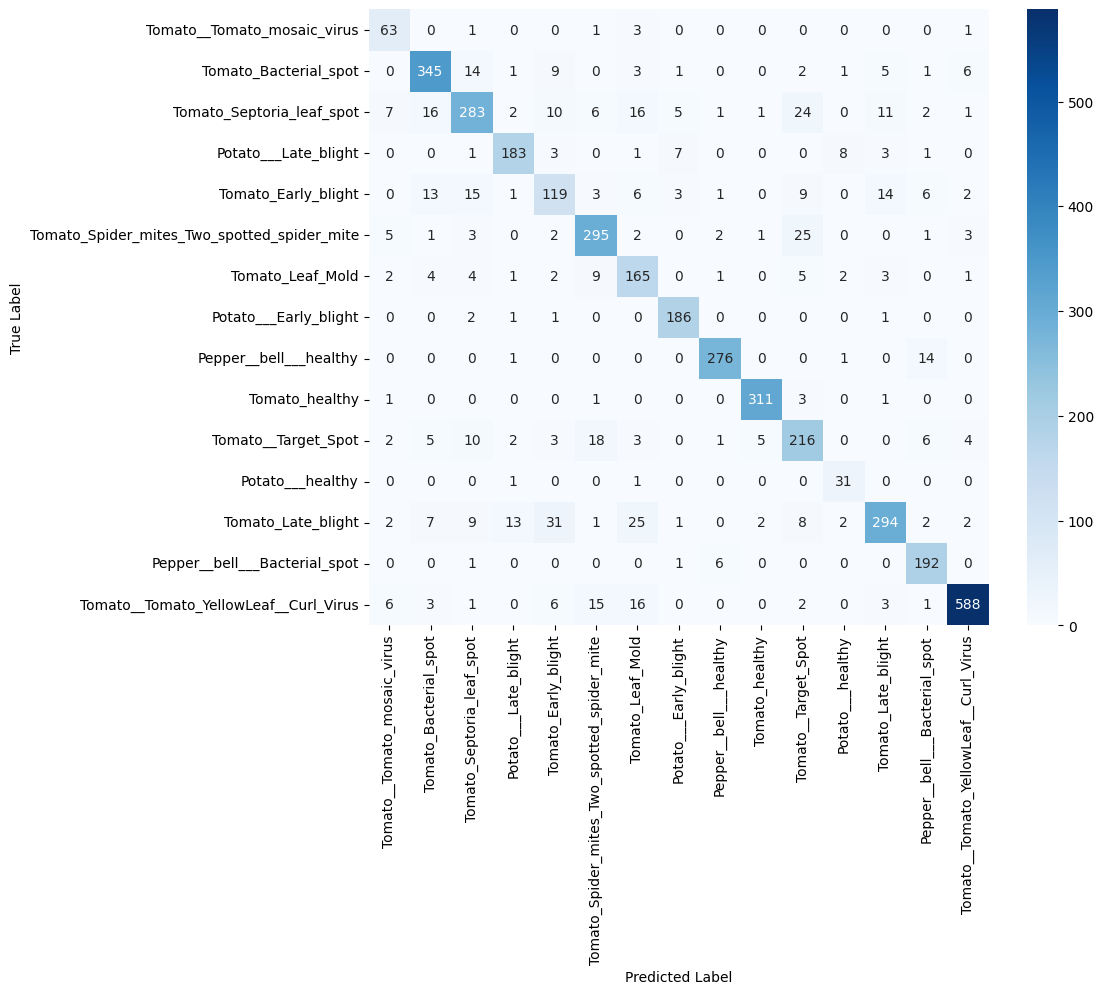


Classification Report:
                                              precision    recall  f1-score   support

                Tomato__Tomato_mosaic_virus       0.72      0.91      0.80        69
                      Tomato_Bacterial_spot       0.88      0.89      0.88       388
                  Tomato_Septoria_leaf_spot       0.82      0.74      0.78       385
                       Potato___Late_blight       0.89      0.88      0.89       207
                        Tomato_Early_blight       0.64      0.62      0.63       192
Tomato_Spider_mites_Two_spotted_spider_mite       0.85      0.87      0.86       340
                           Tomato_Leaf_Mold       0.68      0.83      0.75       199
                      Potato___Early_blight       0.91      0.97      0.94       191
                     Pepper__bell___healthy       0.96      0.95      0.95       292
                             Tomato_healthy       0.97      0.98      0.98       317
                        Tomato__Target_

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, class_names):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


print_confusion_matrix(y_true, y_pred, list(label_map.keys()))

accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Accuracy: {accuracy:.4f}")
